<a href="https://colab.research.google.com/github/AkReposuiii/ML-labs/blob/main/ID3_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:

import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import math

In [114]:
df = pd.read_csv('/content/PlayTennis.csv')
df.head()

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [115]:
# Calculate entropy
def calculate_entropy(data, target_column):
  total_rows = len(data)
  target_values = data[target_column].unique()

  entropy = 0
  for value in target_values:
    value_count = len(data[data[target_column] == value])
    proportion = value_count / total_rows
    entropy -= proportion * math.log2(proportion) if proportion != 0 else 0

  return entropy

In [116]:
def calculate_gini_impurity(data, target_column):
  total_rows = len(data)
  target_values = data[target_column].unique()

  gini = 1
  for value in target_values:
    value_count = len(data[data[target_column] == value])
    proportion = value_count / total_rows
    gini -= proportion ** 2

  return gini

In [117]:
def calculate_information_gain(data, feature, target_column, criterion='entropy'):
  if criterion == 'entropy':
    entropy_func = calculate_entropy
  elif criterion == 'gini':
    entropy_func = calculate_gini_impurity
  else:
    raise ValueError("Invalid criterion. Use 'entropy' or 'gini'.")

  unique_values = data[feature].unique()
  weighted_entropy = 0

  for value in unique_values:
    subset = data[data[feature] == value]
    proportion = len(subset) / len(data)
    weighted_entropy += proportion * entropy_func(subset, target_column)

  if criterion == 'entropy':
    information_gain = calculate_entropy(data, target_column) - weighted_entropy
  else:  # Gini impurity
    information_gain = calculate_gini_impurity(data, target_column) - weighted_entropy

  return information_gain

In [118]:
def id3(data, target_column, features, criterion='entropy'):
    if len(data[target_column].unique()) == 1:
        return data[target_column].iloc[0]
    if len(features) == 0:
        return data[target_column].mode().iloc[0]

    best_feature = max(features, key=lambda x: calculate_information_gain(data, x, target_column, criterion))

    tree = {best_feature: {}}

    features = [f for f in features if f != best_feature]

    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        tree[best_feature][value] = id3(subset, target_column, features, criterion)

    return tree

In [119]:
print("Feasibility Study:")
for column in df.columns[:-1]:
  entropy = calculate_entropy(df, column)
  gini_impurity = calculate_gini_impurity(df, column)
  information_gain_entropy = calculate_information_gain(df, column, 'Play Tennis', 'entropy')
  information_gain_gini = calculate_information_gain(df, column, 'Play Tennis', 'gini')
  print(f"{column} - Entropy: {entropy:.3f}, Gini Impurity: {gini_impurity:.3f}, "
        f"Info Gain (Entropy): {information_gain_entropy:.3f}, "
        f"Info Gain (Gini): {information_gain_gini:.3f}")

Feasibility Study:
Outlook - Entropy: 1.577, Gini Impurity: 0.663, Info Gain (Entropy): 0.247, Info Gain (Gini): 0.116
Temperature - Entropy: 1.557, Gini Impurity: 0.653, Info Gain (Entropy): 0.029, Info Gain (Gini): 0.019
Humidity - Entropy: 1.000, Gini Impurity: 0.500, Info Gain (Entropy): 0.152, Info Gain (Gini): 0.092
Wind - Entropy: 0.985, Gini Impurity: 0.490, Info Gain (Entropy): 0.048, Info Gain (Gini): 0.031


In [106]:

# Split the dataset
X = df.drop('Play Tennis', axis=1)
y = df['Play Tennis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
tree_gini = id3(pd.concat([X_train, y_train], axis=1), 'Play Tennis', X_train.columns, criterion='gini')
print("\nDecision Tree (Gini):")
print(tree_gini)


Decision Tree (Gini):
{'Outlook': {'Overcast': 'Yes', 'Rain': {'Wind': {'Strong': 'No', 'Weak': 'Yes'}}, 'Sunny': {'Humidity': {'Normal': 'Yes', 'High': 'No'}}}}


In [108]:
def predict(instance, tree):
  for feature in tree.keys():
    value = instance[feature]
    if value in tree[feature]:
      subtree = tree[feature][value]
      if isinstance(subtree, dict):
        return predict(instance, subtree)
      else:
        return subtree
    else:
      # Handle cases where the value is not in the tree
      return None

y_pred = [predict(X_test.iloc[i], tree_gini) for i in range(len(X_test))]

In [109]:
def predict(instance, tree):
  for feature in tree.keys():
    value = instance[feature]
    if value in tree[feature]:
      subtree = tree[feature][value]
      if isinstance(subtree, dict):
        return predict(instance, subtree)
      else:
        return subtree
    else:
      # Handle cases where the value is not in the tree
      # Returning a default prediction instead of None
      return 0 # Or 1, depending on your problem

y_pred = [predict(X_test.iloc[i], tree_gini) for i in range(len(X_test))]

In [110]:

print("\nConfusion Matrix:")
print(cm)


accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)





Confusion Matrix:
[[81 18]
 [47  8]]

Accuracy: 1.0


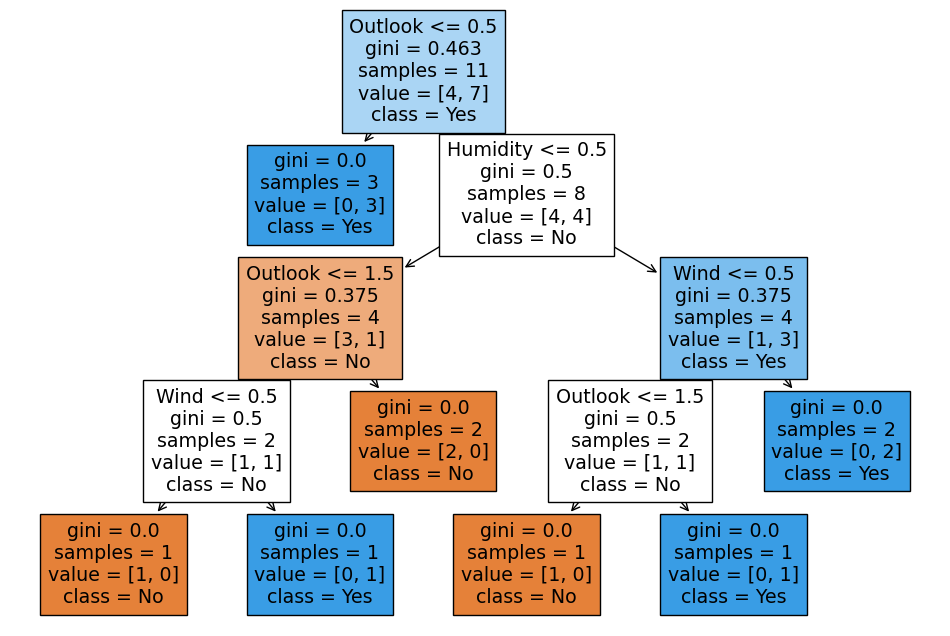

In [111]:
!pip install scikit-learn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Assuming X_train, y_train are your training data
# Create a DecisionTreeClassifier object
clf = DecisionTreeClassifier(criterion='gini')

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate through columns and encode string columns
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col])

# Fit the model to your training data (now with encoded features)
clf.fit(X_train, y_train)

# Now you can plot the tree (note: feature names might be encoded now)
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True)
plt.show()